# Kestrel API Performance Analysis

This notebook analyzes the performance of Kestrel search endpoints against the HMDB ground truth dataset.

**Endpoints Tested:**
- `text-search` - BM25-based lexical matching
- `vector-search` - Embedding-based semantic matching
- `hybrid-search` - Combined text + vector approach

**Ground Truth:**
- 1351 compound names from HMDB
- 7 categories: exact_match, fuzzy_match, special_prefix, greek_letter, synonym_match, numeric_prefix, arivale

**Metrics:**
- Recall@k (k=1, 5, 10, 20, 50, 100)
- MRR (Mean Reciprocal Rank)
- LLM Benefit Score
- Per-category breakdown

In [1]:
# Imports
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Configure display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8-whitegrid')

# Output directory for figures
OUTPUT_DIR = Path('kestrel_analysis_outputs')
OUTPUT_DIR.mkdir(exist_ok=True)

## 1. Load Results

In [2]:
# Load evaluation results
RESULTS_PATH = Path('kestrel_evaluation_results.json')

with open(RESULTS_PATH) as f:
    data = json.load(f)

print("Metadata:")
for key, value in data['metadata'].items():
    print(f"  {key}: {value}")

# Extract endpoints
endpoints = data['metadata']['endpoints_tested']
print(f"\nEndpoints: {endpoints}")

Metadata:
  timestamp: 2026-01-06T07:40:04.769668
  ground_truth_source: /home/trentleslie/Insync/projects/biovector-eval/data/hmdb/ground_truth.json
  total_queries: 1351
  endpoints_tested: ['text-search', 'vector-search', 'hybrid-search']
  limit: 100
  batch_size: 100
  category_filter: SmallMolecule

Endpoints: ['text-search', 'vector-search', 'hybrid-search']


## 2. Investigate API Response Fields

In [3]:
# Examine raw response structure
sample = data['results'][endpoints[0]][0]
print("Sample query result structure:")
print(f"  Query: {sample['query']}")
print(f"  Expected: {sample['expected']}")
print(f"  Category: {sample['category']}")
print(f"  Difficulty: {sample['difficulty']}")
print(f"  Latency: {sample['latency_ms']:.2f}ms")
print(f"\nResponse fields:")
if sample['response']:
    for key in sample['response'][0].keys():
        value = sample['response'][0][key]
        if isinstance(value, list) and len(value) > 3:
            print(f"  {key}: {value[:3]}... ({len(value)} items)")
        else:
            print(f"  {key}: {value}")

Sample query result structure:
  Query: Indalpine
  Expected: ['HMDB0253446']
  Category: exact_match
  Difficulty: easy
  Latency: 14.33ms

Response fields:
  id: CHEBI:134939
  name: indalpine
  categories: ['biolink:ChemicalEntity', 'biolink:Drug', 'biolink:SmallMolecule']
  score: 0.9951578397409693
  neighbors_count: 1666
  prefixes: ['HMDB', 'UMLS', 'UNII']... (12 items)
  synonyms_count: 5
  synonyms: ['INDALPINE', 'Indalpine', 'upstene']... (5 items)
  equivalent_ids_count: 12
  equivalent_ids: ['HMDB:HMDB0253446', 'CHEBI:134939', 'PUBCHEM.COMPOUND:44668']... (12 items)


## 3. Compute Core Metrics

For each query, we check if the expected HMDB ID appears in the `equivalent_ids` of any result.

In [4]:
def normalize_hmdb_id(hmdb_id: str) -> str:
    """Normalize HMDB ID to standard format for comparison.
    
    Ground truth: 'HMDB0253446'
    API returns: 'HMDB:HMDB0253446'
    """
    if hmdb_id.startswith('HMDB:'):
        return hmdb_id[5:]  # Remove 'HMDB:' prefix
    return hmdb_id


def find_match_rank(response: list, expected: list) -> int | None:
    """Find rank (1-indexed) of first result containing expected HMDB ID.
    
    Returns:
        Rank (1-indexed) if found, None if not found
    """
    expected_normalized = {normalize_hmdb_id(e) for e in expected}
    
    for rank, result in enumerate(response, start=1):
        # Check equivalent_ids for HMDB match
        equiv_ids = result.get('equivalent_ids', [])
        for equiv_id in equiv_ids:
            if equiv_id.startswith('HMDB:'):
                normalized = normalize_hmdb_id(equiv_id)
                if normalized in expected_normalized:
                    return rank
    return None


def compute_metrics(results: list) -> dict:
    """Compute recall@k and MRR metrics."""
    k_values = [1, 5, 10, 20, 50, 100]
    metrics = {f'recall@{k}': 0.0 for k in k_values}
    metrics['mrr'] = 0.0
    
    n_queries = len(results)
    if n_queries == 0:
        return metrics
    
    total_rr = 0.0  # Sum of reciprocal ranks
    recall_counts = {k: 0 for k in k_values}
    
    for item in results:
        rank = find_match_rank(item['response'], item['expected'])
        
        if rank is not None:
            # MRR contribution
            total_rr += 1.0 / rank
            
            # Recall@k contributions
            for k in k_values:
                if rank <= k:
                    recall_counts[k] += 1
    
    metrics['mrr'] = total_rr / n_queries
    for k in k_values:
        metrics[f'recall@{k}'] = recall_counts[k] / n_queries
    
    return metrics


# Test on first few results
test_results = data['results'][endpoints[0]][:10]
print("Testing metric computation:")
for item in test_results[:5]:
    rank = find_match_rank(item['response'], item['expected'])
    print(f"  {item['query'][:40]:40} -> Rank: {rank}")

Testing metric computation:
  Indalpine                                -> Rank: 1
  TG(16:1(9Z)/22:2(13Z,16Z)/20:3n6)        -> Rank: 1
  PG(16:1(9Z)/20:3(8Z,11Z,14Z))            -> Rank: 1
  PS(18:0/18:3(9,11,15)-OH(13))            -> Rank: 1
  CL(i-14:0/a-17:0/i-16:0/i-18:0)[rac]     -> Rank: 1


In [5]:
# Compute metrics for each endpoint
endpoint_metrics = {}

for endpoint in endpoints:
    results = data['results'][endpoint]
    metrics = compute_metrics(results)
    endpoint_metrics[endpoint] = metrics
    
    print(f"\n{endpoint}:")
    print(f"  MRR: {metrics['mrr']:.4f}")
    for k in [1, 5, 10, 100]:
        print(f"  Recall@{k}: {metrics[f'recall@{k}']:.4f}")


text-search:
  MRR: 0.5755
  Recall@1: 0.5241
  Recall@5: 0.6403
  Recall@10: 0.6543
  Recall@100: 0.6928

vector-search:
  MRR: 0.1113
  Recall@1: 0.0962
  Recall@5: 0.1288
  Recall@10: 0.1406
  Recall@100: 0.1850

hybrid-search:
  MRR: 0.4773
  Recall@1: 0.4293
  Recall@5: 0.5366
  Recall@10: 0.5551
  Recall@100: 0.6247


## 4. Summary Statistics by Endpoint

In [6]:
# Build summary DataFrame
k_values = [1, 5, 10, 20, 50, 100]
rows = []

for endpoint in endpoints:
    metrics = endpoint_metrics[endpoint]
    row = {'endpoint': endpoint}
    row['mrr'] = metrics['mrr']
    for k in k_values:
        row[f'recall@{k}'] = metrics[f'recall@{k}']
    
    # Compute LLM benefit score
    if metrics['recall@100'] > 0:
        row['llm_benefit_score'] = (metrics['recall@100'] - metrics['recall@1']) / metrics['recall@100']
    else:
        row['llm_benefit_score'] = 0.0
    
    # Compute gains
    row['gain_1_5'] = metrics['recall@5'] - metrics['recall@1']
    row['gain_5_10'] = metrics['recall@10'] - metrics['recall@5']
    row['gain_10_100'] = metrics['recall@100'] - metrics['recall@10']
    
    # Compute latency stats
    results = data['results'][endpoint]
    latencies = [r['latency_ms'] for r in results]
    row['p50_ms'] = np.percentile(latencies, 50)
    row['p95_ms'] = np.percentile(latencies, 95)
    row['p99_ms'] = np.percentile(latencies, 99)
    
    rows.append(row)

df_summary = pd.DataFrame(rows)

# Display with formatting
print("\nSummary Statistics by Endpoint:")
display(df_summary.style.format({
    'mrr': '{:.4f}',
    **{f'recall@{k}': '{:.4f}' for k in k_values},
    'llm_benefit_score': '{:.2%}',
    'gain_1_5': '{:.4f}',
    'gain_5_10': '{:.4f}',
    'gain_10_100': '{:.4f}',
    'p50_ms': '{:.1f}',
    'p95_ms': '{:.1f}',
    'p99_ms': '{:.1f}',
}))


Summary Statistics by Endpoint:


,endpoint,mrr,recall@1,recall@5,recall@10,recall@20,recall@50,recall@100,llm_benefit_score,gain_1_5,gain_5_10,gain_10_100,p50_ms,p95_ms,p99_ms
0,text-search,0.5755,0.5241,0.6403,0.6543,0.6691,0.6854,0.6928,24.36%,0.1162,0.0141,0.0385,24.0,52.3,52.3
1,vector-search,0.1113,0.0962,0.1288,0.1406,0.1525,0.1754,0.1850,48.00%,0.0326,0.0118,0.0444,20.6,25.8,25.8
2,hybrid-search,0.4773,0.4293,0.5366,0.5551,0.5774,0.6077,0.6247,31.28%,0.1073,0.0185,0.0696,43.9,71.7,71.7


## 5. Per-Category Breakdown

In [7]:
# Get unique categories
all_results = []
for endpoint in endpoints:
    for item in data['results'][endpoint]:
        all_results.append(item)

categories = sorted(set(r['category'] for r in data['results'][endpoints[0]]))
print(f"Categories: {categories}")
print(f"\nCategory counts:")
for cat in categories:
    count = sum(1 for r in data['results'][endpoints[0]] if r['category'] == cat)
    print(f"  {cat}: {count}")

Categories: ['arivale', 'exact_match', 'fuzzy_match', 'greek_letter', 'numeric_prefix', 'special_prefix', 'synonym_match']

Category counts:
  arivale: 651
  exact_match: 150
  fuzzy_match: 100
  greek_letter: 100
  numeric_prefix: 100
  special_prefix: 100
  synonym_match: 150


In [8]:
# Compute metrics by category for each endpoint
category_metrics = []

for endpoint in endpoints:
    for category in categories:
        cat_results = [r for r in data['results'][endpoint] if r['category'] == category]
        if not cat_results:
            continue
        
        metrics = compute_metrics(cat_results)
        row = {
            'endpoint': endpoint,
            'category': category,
            'count': len(cat_results),
            'mrr': metrics['mrr'],
        }
        for k in [1, 5, 10, 100]:
            row[f'recall@{k}'] = metrics[f'recall@{k}']
        category_metrics.append(row)

df_category = pd.DataFrame(category_metrics)

# Pivot for better display
print("\nRecall@1 by Category and Endpoint:")
pivot_recall1 = df_category.pivot(index='category', columns='endpoint', values='recall@1')
display(pivot_recall1.style.format('{:.4f}').background_gradient(cmap='RdYlGn', axis=None))


Recall@1 by Category and Endpoint:


endpoint,hybrid-search,text-search,vector-search
category,,,
arivale,0.3226,0.4147,0.0077
exact_match,0.6333,0.9800,0.2533
fuzzy_match,0.0500,0.0200,0.0500
greek_letter,0.8700,0.9700,0.3400
numeric_prefix,0.9100,0.9500,0.2500
special_prefix,0.8400,0.8500,0.2200
synonym_match,0.0533,0.0800,0.0067


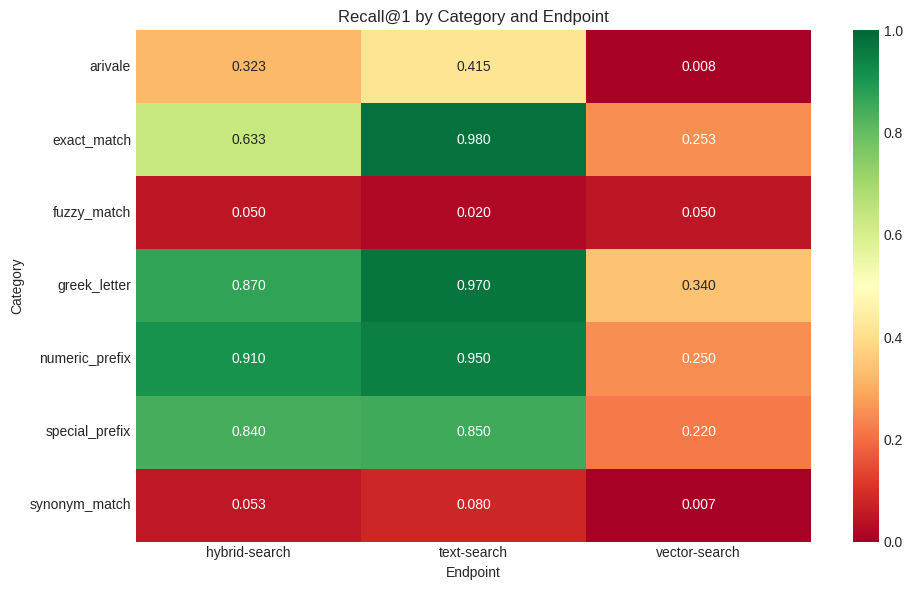

In [9]:
# Heatmap: Category x Endpoint Recall@1
fig, ax = plt.subplots(figsize=(10, 6))

sns.heatmap(
    pivot_recall1,
    annot=True,
    fmt='.3f',
    cmap='RdYlGn',
    ax=ax,
    vmin=0,
    vmax=1,
)
ax.set_title('Recall@1 by Category and Endpoint')
ax.set_xlabel('Endpoint')
ax.set_ylabel('Category')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'recall_category_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Recall@k Progression Analysis

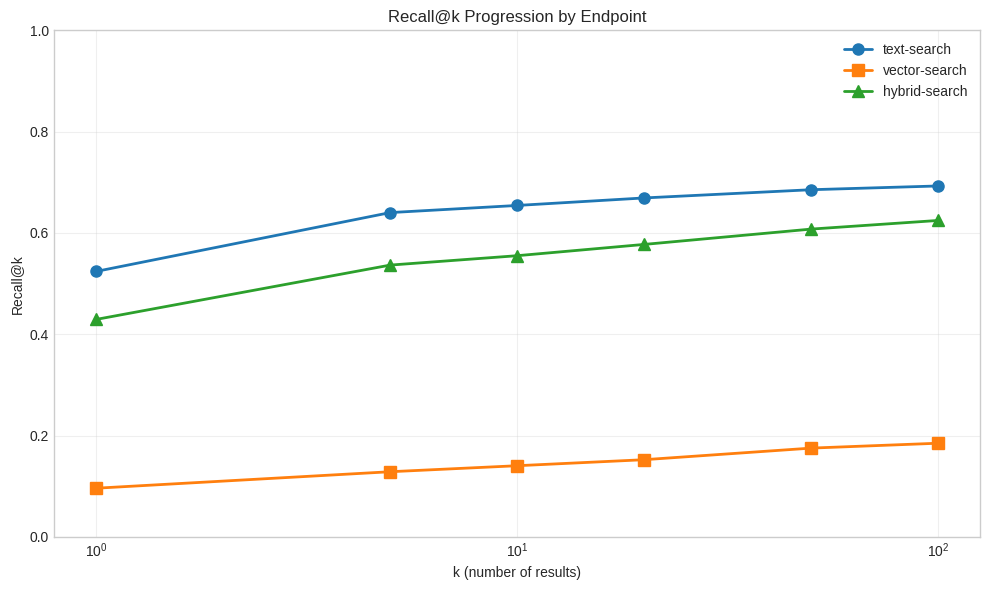

In [10]:
# Recall@k progression curves
k_values = [1, 5, 10, 20, 50, 100]

fig, ax = plt.subplots(figsize=(10, 6))

colors = {'text-search': '#1f77b4', 'vector-search': '#ff7f0e', 'hybrid-search': '#2ca02c'}
markers = {'text-search': 'o', 'vector-search': 's', 'hybrid-search': '^'}

for endpoint in endpoints:
    recalls = [endpoint_metrics[endpoint][f'recall@{k}'] for k in k_values]
    ax.plot(
        k_values, recalls,
        marker=markers.get(endpoint, 'o'),
        color=colors.get(endpoint, None),
        label=endpoint,
        linewidth=2,
        markersize=8,
    )

ax.set_xlabel('k (number of results)')
ax.set_ylabel('Recall@k')
ax.set_title('Recall@k Progression by Endpoint')
ax.set_xscale('log')
ax.set_ylim(0, 1)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'recall_at_k_progression.png', dpi=150, bbox_inches='tight')
plt.show()

In [11]:
# LLM Benefit Analysis
print("LLM Benefit Score (potential gain from re-ranking):")
print("Score = (Recall@100 - Recall@1) / Recall@100")
print("Higher score = more benefit from LLM re-ranking\n")

for _, row in df_summary.iterrows():
    endpoint = row['endpoint']
    r1 = row['recall@1']
    r100 = row['recall@100']
    score = row['llm_benefit_score']
    headroom = r100 - r1
    print(f"{endpoint}:")
    print(f"  Recall@1: {r1:.4f}, Recall@100: {r100:.4f}")
    print(f"  LLM Headroom: {headroom:.4f} ({score:.1%} of max)")

LLM Benefit Score (potential gain from re-ranking):
Score = (Recall@100 - Recall@1) / Recall@100
Higher score = more benefit from LLM re-ranking

text-search:
  Recall@1: 0.5241, Recall@100: 0.6928
  LLM Headroom: 0.1688 (24.4% of max)
vector-search:
  Recall@1: 0.0962, Recall@100: 0.1850
  LLM Headroom: 0.0888 (48.0% of max)
hybrid-search:
  Recall@1: 0.4293, Recall@100: 0.6247
  LLM Headroom: 0.1954 (31.3% of max)


## 7. Score Analysis

In [12]:
# Analyze score distributions for correct vs incorrect matches
def classify_result(item):
    """Classify result as correct/incorrect and get top-1 score."""
    rank = find_match_rank(item['response'], item['expected'])
    is_correct = rank == 1  # Correct if expected is top-1
    
    top_score = None
    if item['response']:
        top_score = item['response'][0].get('score')
    
    return is_correct, top_score, rank


score_data = []
for endpoint in endpoints:
    for item in data['results'][endpoint]:
        is_correct, top_score, rank = classify_result(item)
        if top_score is not None:
            score_data.append({
                'endpoint': endpoint,
                'query': item['query'],
                'category': item['category'],
                'is_correct': is_correct,
                'top_score': top_score,
                'correct_rank': rank,
            })

df_scores = pd.DataFrame(score_data)
print(f"Score data shape: {df_scores.shape}")
df_scores.head()

Score data shape: (3861, 6)


,endpoint,query,category,is_correct,top_score,correct_rank
0,text-search,Indalpine,exact_match,True,0.995158,1.0
1,text-search,"TG(16:1(9Z)/22:2(13Z,16Z)/20:3n6)",exact_match,True,0.908862,1.0
2,text-search,"PG(16:1(9Z)/20:3(8Z,11Z,14Z))",exact_match,True,0.948882,1.0
3,text-search,"PS(18:0/18:3(9,11,15)-OH(13))",exact_match,True,0.885289,1.0
4,text-search,CL(i-14:0/a-17:0/i-16:0/i-18:0)[rac],exact_match,True,0.965467,1.0


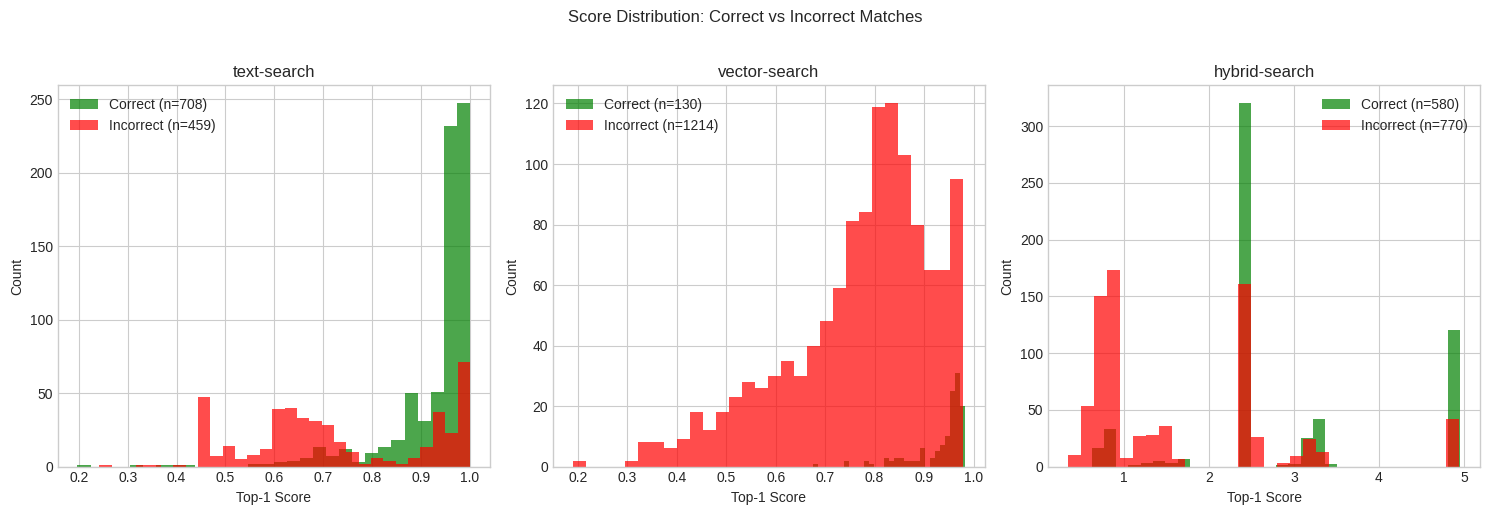

In [13]:
# Score distribution: correct vs incorrect
fig, axes = plt.subplots(1, len(endpoints), figsize=(5*len(endpoints), 5))
if len(endpoints) == 1:
    axes = [axes]

for ax, endpoint in zip(axes, endpoints):
    df_ep = df_scores[df_scores['endpoint'] == endpoint]
    
    correct_scores = df_ep[df_ep['is_correct']]['top_score']
    incorrect_scores = df_ep[~df_ep['is_correct']]['top_score']
    
    ax.hist(correct_scores, bins=30, alpha=0.7, label=f'Correct (n={len(correct_scores)})', color='green')
    ax.hist(incorrect_scores, bins=30, alpha=0.7, label=f'Incorrect (n={len(incorrect_scores)})', color='red')
    
    ax.set_xlabel('Top-1 Score')
    ax.set_ylabel('Count')
    ax.set_title(f'{endpoint}')
    ax.legend()

plt.suptitle('Score Distribution: Correct vs Incorrect Matches', y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'score_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Error Analysis

In [14]:
# Identify failure patterns
def analyze_failures(results: list) -> pd.DataFrame:
    """Analyze failed queries (not found in top-1)."""
    failures = []
    for item in results:
        rank = find_match_rank(item['response'], item['expected'])
        if rank != 1:  # Not correct at top-1
            top_result = None
            if item['response']:
                top_result = {
                    'id': item['response'][0].get('id'),
                    'name': item['response'][0].get('name'),
                    'score': item['response'][0].get('score'),
                }
            failures.append({
                'query': item['query'],
                'expected': item['expected'],
                'category': item['category'],
                'correct_rank': rank,
                'top_result': top_result,
            })
    return pd.DataFrame(failures)


# Analyze failures for best endpoint
best_endpoint = df_summary.loc[df_summary['recall@1'].idxmax(), 'endpoint']
print(f"Analyzing failures for best endpoint: {best_endpoint}")

df_failures = analyze_failures(data['results'][best_endpoint])
print(f"\nTotal failures (not in top-1): {len(df_failures)}")

# Failure by category
print("\nFailures by category:")
failure_counts = df_failures['category'].value_counts()
total_counts = pd.Series([r['category'] for r in data['results'][best_endpoint]]).value_counts()
for cat in categories:
    n_fail = failure_counts.get(cat, 0)
    n_total = total_counts.get(cat, 0)
    fail_rate = n_fail / n_total if n_total > 0 else 0
    print(f"  {cat}: {n_fail}/{n_total} ({fail_rate:.1%} failure rate)")

Analyzing failures for best endpoint: text-search

Total failures (not in top-1): 643

Failures by category:
  arivale: 381/651 (58.5% failure rate)
  exact_match: 3/150 (2.0% failure rate)
  fuzzy_match: 98/100 (98.0% failure rate)
  greek_letter: 3/100 (3.0% failure rate)
  numeric_prefix: 5/100 (5.0% failure rate)
  special_prefix: 15/100 (15.0% failure rate)
  synonym_match: 138/150 (92.0% failure rate)


In [15]:
# Sample of failures by category
print(f"\nSample failures from {best_endpoint}:\n")

for cat in categories:
    cat_failures = df_failures[df_failures['category'] == cat]
    if len(cat_failures) > 0:
        print(f"\n{cat} ({len(cat_failures)} failures):")
        for _, row in cat_failures.head(3).iterrows():
            query = row['query'][:50]
            expected = row['expected'][0] if row['expected'] else 'N/A'
            rank = row['correct_rank']
            rank_str = f"rank {rank}" if rank else "not found"
            print(f"  '{query}...' -> Expected: {expected}, Found at: {rank_str}")


Sample failures from text-search:


arivale (381 failures):
  'pyridoxate...' -> Expected: HMDB0000017, Found at: rank 6.0
  '3-methyl-2-oxobutyrate...' -> Expected: HMDB0000019, Found at: rank 2.0
  '4-hydroxyphenylacetate...' -> Expected: HMDB0000020, Found at: rank 3.0

exact_match (3 failures):
  'Chlorprothixene sulfoxide...' -> Expected: HMDB0250136, Found at: rank 2.0
  'Pazufloxacin...' -> Expected: HMDB0256145, Found at: rank 3.0
  'Avenacoside B...' -> Expected: HMDB0033802, Found at: rank 2.0

fuzzy_match (98 failures):
  'PC(20:3(6,8,11-OH(5o/Die(13,5))...' -> Expected: HMDB0289212, Found at: rank nan
  'TG(20:4(5Z,8Z,11Z1,4Z)/14u1(9Z)/22:5(7Z,10Z,13S,16...' -> Expected: HMDB0054097, Found at: rank nan
  'Glucose-6-phoshafe lactate...' -> Expected: HMDB0252789, Found at: rank nan

greek_letter (3 failures):
  'gamma-Glutamyldopa...' -> Expected: HMDB0252797, Found at: rank 2.0
  '2''-O-alpha-L-Rhamnosyl-6-C-quinovopyranosyl-luteo...' -> Expected: HMDB0301973, Found at: ran

## 9. Latency Analysis

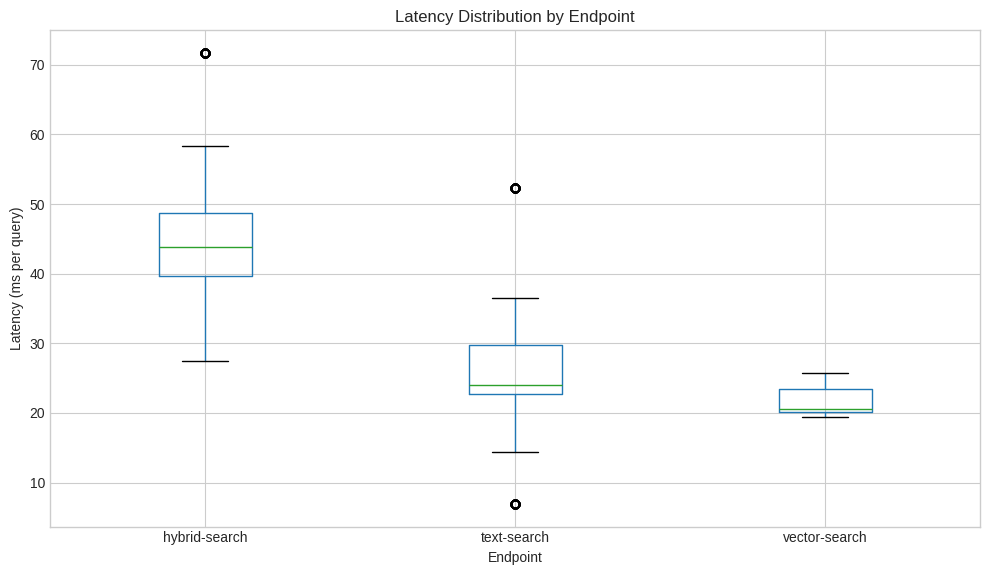


Latency Statistics (ms per query):
                count   mean    std    min    25%    50%    75%    max
endpoint                                                              
hybrid-search  1351.0  45.18  10.51  27.46  39.66  43.89  48.66  71.70
text-search    1351.0  25.83  10.79   6.93  22.74  24.03  29.78  52.35
vector-search  1351.0  21.76   2.11  19.46  20.13  20.62  23.48  25.78


In [16]:
# Latency comparison
latency_data = []
for endpoint in endpoints:
    for item in data['results'][endpoint]:
        latency_data.append({
            'endpoint': endpoint,
            'latency_ms': item['latency_ms'],
        })

df_latency = pd.DataFrame(latency_data)

# Box plot
fig, ax = plt.subplots(figsize=(10, 6))

df_latency.boxplot(column='latency_ms', by='endpoint', ax=ax)
ax.set_xlabel('Endpoint')
ax.set_ylabel('Latency (ms per query)')
ax.set_title('Latency Distribution by Endpoint')
plt.suptitle('')  # Remove auto-generated title

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'latency_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Latency stats
print("\nLatency Statistics (ms per query):")
print(df_latency.groupby('endpoint')['latency_ms'].describe().round(2))

## 10. Recall Comparison Bar Chart

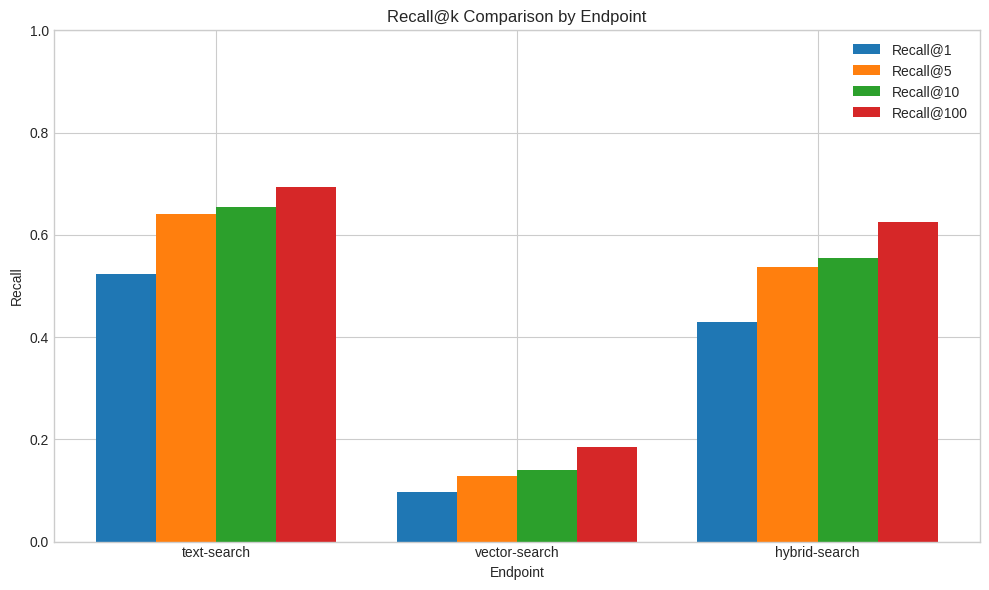

In [17]:
# Bar chart: Recall@1 by endpoint
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(endpoints))
width = 0.2

k_to_plot = [1, 5, 10, 100]
colors_k = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, k in enumerate(k_to_plot):
    recalls = [endpoint_metrics[ep][f'recall@{k}'] for ep in endpoints]
    ax.bar(x + i*width, recalls, width, label=f'Recall@{k}', color=colors_k[i])

ax.set_xlabel('Endpoint')
ax.set_ylabel('Recall')
ax.set_title('Recall@k Comparison by Endpoint')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(endpoints)
ax.legend()
ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'recall_comparison_bars.png', dpi=150, bbox_inches='tight')
plt.show()

## 11. Summary & Recommendations

In [18]:
# Final summary
print("="*60)
print("SUMMARY & RECOMMENDATIONS")
print("="*60)

# Best endpoint
best_r1_idx = df_summary['recall@1'].idxmax()
best_r1 = df_summary.loc[best_r1_idx]
print(f"\nBest Recall@1: {best_r1['endpoint']} ({best_r1['recall@1']:.4f})")

best_mrr_idx = df_summary['mrr'].idxmax()
best_mrr = df_summary.loc[best_mrr_idx]
print(f"Best MRR: {best_mrr['endpoint']} ({best_mrr['mrr']:.4f})")

# LLM potential
print("\nLLM Re-ranking Potential:")
for _, row in df_summary.iterrows():
    headroom = row['recall@100'] - row['recall@1']
    print(f"  {row['endpoint']}: {headroom:.4f} additional recall possible with perfect re-ranking")

# Category insights
print("\nCategory Insights (best endpoint):")
best_ep_cats = df_category[df_category['endpoint'] == best_r1['endpoint']]
worst_cat = best_ep_cats.loc[best_ep_cats['recall@1'].idxmin()]
best_cat = best_ep_cats.loc[best_ep_cats['recall@1'].idxmax()]
print(f"  Best category: {best_cat['category']} (Recall@1: {best_cat['recall@1']:.4f})")
print(f"  Worst category: {worst_cat['category']} (Recall@1: {worst_cat['recall@1']:.4f})")

print("\n" + "="*60)

SUMMARY & RECOMMENDATIONS

Best Recall@1: text-search (0.5241)
Best MRR: text-search (0.5755)

LLM Re-ranking Potential:
  text-search: 0.1688 additional recall possible with perfect re-ranking
  vector-search: 0.0888 additional recall possible with perfect re-ranking
  hybrid-search: 0.1954 additional recall possible with perfect re-ranking

Category Insights (best endpoint):
  Best category: exact_match (Recall@1: 0.9800)
  Worst category: fuzzy_match (Recall@1: 0.0200)



In [19]:
# Save summary statistics to CSV
df_summary.to_csv(OUTPUT_DIR / 'endpoint_summary.csv', index=False)
df_category.to_csv(OUTPUT_DIR / 'category_breakdown.csv', index=False)
print(f"Summary saved to {OUTPUT_DIR}/")

Summary saved to kestrel_analysis_outputs/
